In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import datetime as dt
from matplotlib.artist import setp
from cartopy import feature as cfeature

In [2]:
# load data
era5_1 = xr.open_mfdataset("/g/data/tp28/dev/eh6215/qflux/ERA5/qflux*133E_18S.nc")
era5 = xr.open_mfdataset("/g/data/tp28/dev/eh6215/qflux/ERA5/int*133E_18S.nc")

In [3]:
# combine into one dataset
era5['moisture_flux'] = era5_1['moisture_flux']

In [4]:
# switch to daily and load into memory
era5 = era5.resample(time='1D').mean().load()

In [5]:
# align variable names, calc evap from latent heat
era5 = era5.rename({'mtpr':'pr','tcw':'prw'})

# in ERA5, evaporation is downwards, and in units of m/hr. (wheras we need mm/s)
era5['e']=era5['e']/-3.6

In [6]:
# moisture flux is saved as flux out of domain. I find this confusing. Multiply by -1 to switch to flux into domain
era5['moisture_flux'] =  -1*era5['moisture_flux'] 

2012
2013
2014
2015
2016
2017
2018
2019
2020


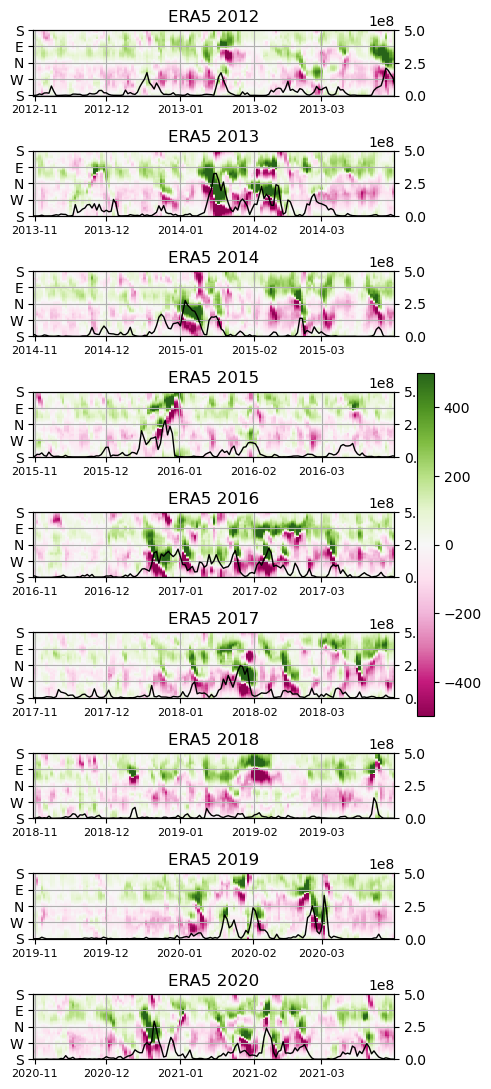

In [7]:
# plot hovmollers of full moisture flux datasets
plt.figure(figsize=(15,12))
ax=[]
for year in range(2012,2021):
    print(year)
    for j,data in enumerate([era5]):    
        ax.append(plt.subplot(10,3,3*(year-2012)+1+j))
        a=data.moisture_flux.sel(time=slice(f"{year}-11",f"{year+1}-03")).roll(bearing=180).T.plot(vmax=500,cmap='PiYG',add_colorbar=False)
        plt.yticks([0,90,180,270,360],['S','W','N','E','S'])
        plt.xlabel("")
        plt.ylabel("")
        plt.grid()
        setp(ax[-1].get_xticklabels(), rotation=0,fontsize=8,ha='center') 
        plt.title(f"")     
        ax2=ax[-1].twinx()
        (data.pr).plot(c='k',lw=1)
        ax2.set_ylim(0,5e8)
        plt.ylabel("")
        plt.title(f"{['ERA5'][j]} {year}")     

plt.tight_layout()
plt.colorbar(a,ax=ax,shrink=1/3)

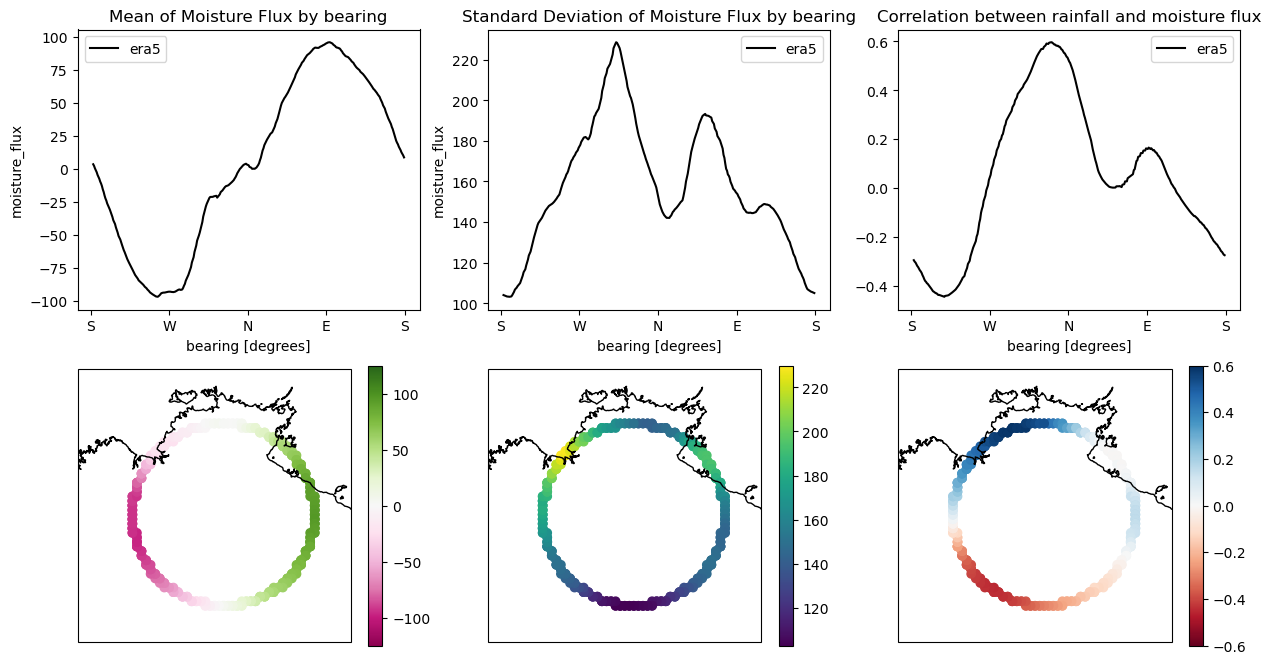

In [8]:
# maps and line-plots of basic statistics

plt.figure(figsize=(15,8))
plt.subplot(231)
era5.moisture_flux.sel(time=era5.time.dt.month.isin([11,12,1,2,3])).mean('time').roll(bearing=180).rolling(bearing=4).mean().plot(label='era5',c='k')
plt.xticks([0,90,180,270,360],['S','W','N','E','S'])
plt.legend()
plt.title("Mean of Moisture Flux by bearing")

plt.subplot(232)
era5.moisture_flux.sel(time=era5.time.dt.month.isin([11,12,1,2,3])).std('time').roll(bearing=180).rolling(bearing=4).mean().plot(label='era5',c='k')
plt.xticks([0,90,180,270,360],['S','W','N','E','S'])
plt.legend()
plt.title("Standard Deviation of Moisture Flux by bearing")

plt.subplot(233)
xr.corr(era5.moisture_flux.sel(time=era5.time.dt.month.isin([11,12,1,2,3])).roll(bearing=180),era5.pr,'time').rolling(bearing=4).mean().plot(label='era5',c='k')
plt.xticks([0,90,180,270,360],['S','W','N','E','S'])
plt.legend()
plt.title("Correlation between rainfall and moisture flux")

ax=plt.subplot(234,projection=ccrs.PlateCarree())
plt.scatter(era5.lon,era5.lat,c=era5.moisture_flux.sel(time=era5.time.dt.month.isin([11,12,1,2,3])).mean('time'),vmin=-125,vmax=125,cmap='PiYG')
plt.colorbar()
plt.xlim(125,140)
plt.ylim(-25,-10)
ax.coastlines()
ax.add_feature(cfeature.BORDERS)

ax=plt.subplot(235,projection=ccrs.PlateCarree())
plt.scatter(era5.lon,era5.lat,c=era5.moisture_flux.sel(time=era5.time.dt.month.isin([11,12,1,2,3])).std('time'))
plt.colorbar()
plt.xlim(125,140)
plt.ylim(-25,-10)
ax.coastlines()
ax.add_feature(cfeature.BORDERS)

ax=plt.subplot(236,projection=ccrs.PlateCarree())
plt.scatter(era5.lon,era5.lat,c=xr.corr(era5.moisture_flux.sel(time=era5.time.dt.month.isin([11,12,1,2,3])),era5.pr,'time'),vmin=-0.6,vmax=0.6,cmap='RdBu')
plt.colorbar()
plt.xlim(125,140)
plt.ylim(-25,-10)
ax.coastlines()
ax.add_feature(cfeature.BORDERS)

In [9]:
# compute arc-lengths around circle


r=6371000
era5['dx'] = np.sqrt((2*np.pi*r/360*(era5.lat - era5.lat.shift(bearing=1,)))**2
             +(2*np.pi*r/360*np.cos(era5.lat*np.pi/180)*(era5.lon - era5.lon.shift(bearing=1)))**2)


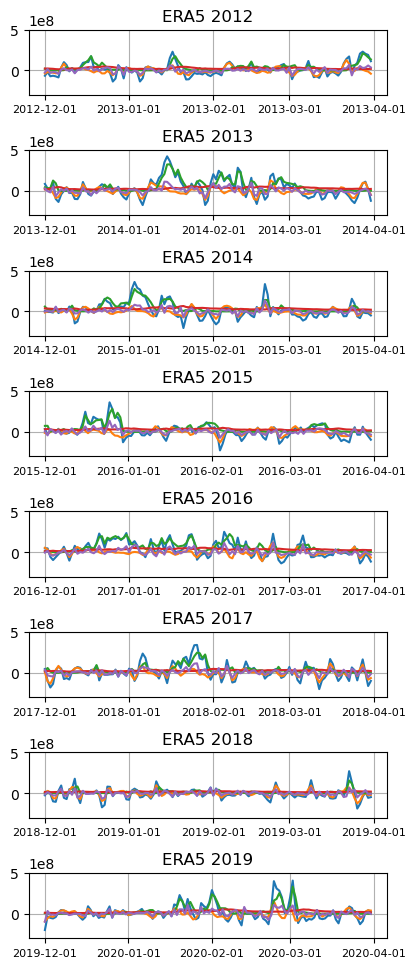

In [10]:
# full timeseries of moisture budgets

plt.figure(figsize=(12,12))
for year in range(2012,2020):
    for j,data in enumerate([era5]):    
        ax=plt.subplot(10,3,3*(year-2012)+j+1)
        timeslice = slice(f"{year}-12",f"{year+1}-3")
        (data.moisture_flux*data.dx).sum('bearing').sel(time=timeslice).plot(label='flux')
        (data.prw).differentiate('time',datetime_unit='s').sel(time=timeslice).plot(label='ddt')
        (data.pr).sel(time=timeslice).plot(label='pr')
        (data.e).sel(time=timeslice).plot(label='evap')
        data['resid'] = -(data.prw).differentiate('time',datetime_unit='s') + (data.e) - (data.pr) + (data.moisture_flux*data.dx).sum('bearing')
        data.resid.sel(time=timeslice).plot(label='resid')
        plt.ylim(-3e8,5e8)
        plt.title(f"{['ERA5'][j]} {year}")     
        plt.xticks([dt.datetime(year,12,1),dt.datetime(year+1,1,1),dt.datetime(year+1,2,1),dt.datetime(year+1,3,1),dt.datetime(year+1,4,1)])
        plt.grid()
        setp(ax.get_xticklabels(), rotation=0,fontsize=8,ha='center') 
        plt.xlabel("")
        plt.ylabel("")
        
plt.tight_layout()
#plt.legend()


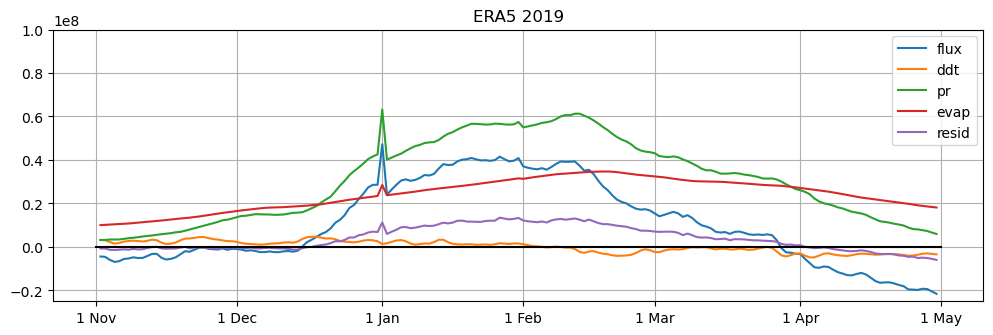

In [11]:
# smoothed climatological moisture budgets
# spike on 1/jan is a boundary effect

plt.figure(figsize=(12,12))
for j,data in enumerate([era5]):    
        data['ddt'] = (data.prw).differentiate('time',datetime_unit='s')
        ax=plt.subplot(3,1,j+1)
        data = data.rolling(time=30).mean().groupby('time.dayofyear').mean().roll(dayofyear=61)
        timeslice = data.dayofyear < 30*6
        (data.moisture_flux*data.dx).sum('bearing').sel(dayofyear=timeslice).plot(label='flux')
        (data.ddt).sel(dayofyear=timeslice).plot(label='ddt')
        (data.pr).sel(dayofyear=timeslice).plot(label='pr')
        (data.e).sel(dayofyear=timeslice).plot(label='evap')
        data.resid.sel(dayofyear=timeslice).plot(label='resid')
        plt.ylim(-0.25e8,1e8)
        plt.title(f"{['ERA5'][j]} {year}")     
        plt.xticks(np.cumsum([0,30,31,30,28,31,30]),['1 Nov','1 Dec', '1 Jan', '1 Feb','1 Mar','1 Apr','1 May'])
        plt.grid()
        setp(ax.get_xticklabels(), rotation=0,ha='center') 
        plt.xlabel("")
        plt.ylabel("")
        plt.legend()
        plt.plot([0,30*6],[0,0],c='k')
    

In [12]:
# compute budget terms

budget  = {}
for j,data in enumerate([era5]): 
    data=data.sel(time=data.time.dt.month.isin([11,12,1,2,3]))
    var = 'ERA5'
    budget[var] = {}
    budget[var]['ddt'] = (data.prw).differentiate('time',datetime_unit='s')
    budget[var]['qflux'] = (data.moisture_flux*data.dx).sum('bearing')
    budget[var]['pr'] =  (data.pr)
    budget[var]['evap'] = (data.e)
    budget[var]['resid'] = data['resid']


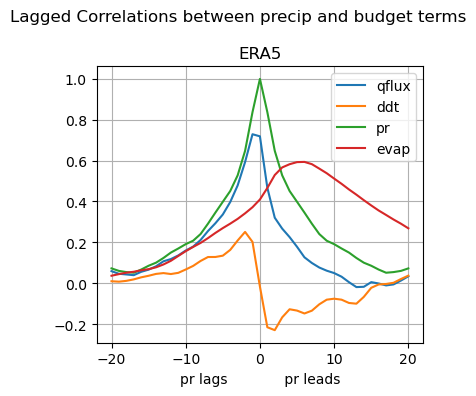

In [13]:
# lagged correlations of pr with budget terms

corr = {}
plt.figure(figsize=(4,4))

for k,var in enumerate(budget):
    for i,key1 in enumerate(['pr',]):
        plt.subplot(1,1,1+k)
        for j,key2 in enumerate([ 'qflux','ddt','pr', 'evap']):
            if 1:
                corr[key1+"_"+key2] = []
                for lag in range(-20,21):
                    corr[key1+"_"+key2].append(xr.corr(budget[var][key2].sel(time=budget[var][key2].time.dt.month.isin([11,12,1,2,3])),
                              budget[var][key1].shift(time=lag).sel(time=budget[var][key1].time.dt.month.isin([11,12,1,2,3])),'time'))
                corr[key1+"_"+key2] = xr.concat(corr[key1+"_"+key2],dim='lag')
                corr[key1+"_"+key2]['lag']=np.arange(-20,21)
            corr[key1+"_"+key2].plot(label=key2)
        plt.xlabel(f"{key1} lags             {key1} leads")
        plt.legend()
        plt.title(var)
        plt.grid()

plt.suptitle("Lagged Correlations between precip and budget terms")
plt.tight_layout()
        

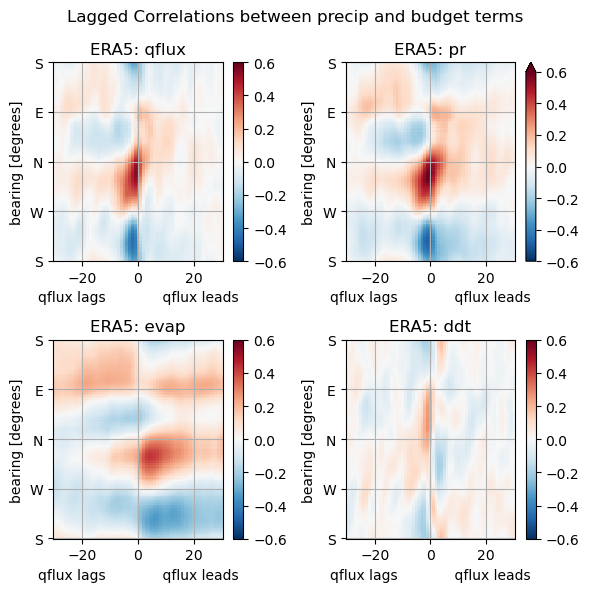

In [14]:
# lagged correlations of moisture flux and budget terms

corr = {}
plt.figure(figsize=(6,6))

for k,var in enumerate(budget):
    for j,key2 in enumerate(['qflux', 'pr', 'evap','ddt']):
        corr[key1+"_"+key2] = []
        data = [era5][k]
        plt.subplot(2,2,k+1+j)
        for lag in range(-30,31):
            corr[key1+"_"+key2].append(xr.corr(budget[var][key2].sel(time=budget[var][key2].time.dt.month.isin([11,12,1,2,3])),
                      data['moisture_flux'].shift(time=lag).sel(time=data['moisture_flux'].time.dt.month.isin([11,12,1,2,3])),'time'))
        corr[key1+"_"+key2] = xr.concat(corr[key1+"_"+key2],dim='lag')
        corr[key1+"_"+key2]['lag']=np.arange(-30,31)
        corr[key1+"_"+key2].roll(bearing=180).T.plot(vmax=0.6)
        plt.yticks([0,90,180,270,360],['S','W','N','E','S'])
        plt.xlabel(f"qflux lags             qflux leads")
        plt.title(f"{var}: {key2}")
        plt.grid()

plt.suptitle("Lagged Correlations between precip and budget terms")
plt.tight_layout()
        